实现卷积层和池化层，包括前向传播和（可选）反向传播。

符号说明：
- $n_H$, $n_W$ and $n_C$ denote respectively the height, width and number of channels of a given layer. If you want to reference a specific layer $l$, you can also write $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$. 
- $n_{H_{prev}}$, $n_{W_{prev}}$ and $n_{C_{prev}}$ denote respectively the height, width and number of channels of the previous layer. If referencing a specific layer $l$, this could also be denoted $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$. 

## 1. packages

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2. 任务梳理
将要实现卷积神经的基本块，要实现的每个都有详细的指示。

卷积层函数：
- 0 padding
- 卷积窗口
- 卷积正向
- 卷积反向

池化层函数：
- 池化正向
- 创建面具mask
- Distribute value
- 反向传播

这节将从头开始（from scratch）实现这些函数，并且使用tensorflow等价实现下面的模型：
![卷积网络结构](https://upload-images.jianshu.io/upload_images/1779926-88a55eb081cb9d94.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)
对应每一个正向函数，都会有对应的反向传播公式。因此，在正向传播的每一步都会存储参数parameters到一个cache中，这些参数将用于计算梯度下降在反向传播过程中。

## 3. 卷积神经网络
### 3.1 0 padding
就是添加0到图片的边缘上的函数，实现效果如图：
![0 padding填充函数](https://upload-images.jianshu.io/upload_images/1779926-e0fee2d7e8f77a44.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

填充的主要好处：
1. 允许使用卷积层后没有对高和宽进行压缩，建立深度网络时候这很重要。一个重要的类别：same padding，即是在一个卷积操作过后，图片的高和宽都没有改变。
2. 帮助我们保留更多关于图片边缘的信息，如果没有填充，图像边缘信息就会丢失。

关于np.pad函数用法的csdn博客：https://blog.csdn.net/qq_36332685/article/details/78803622

**Exercise**: Implement the following function, which pads all the images of a batch of examples X with zeros. [Use np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html). Note if you want to pad the array "a" of shape $(5,5,5,5,5)$ with `pad = 1` for the 2nd dimension, `pad = 3` for the 4th dimension and `pad = 0` for the rest, you would do:
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), 'constant', constant_values = (..,..))
```

如果将一个维度为(5,5,5,5,5)表示5维的5*5*5*5*5的一个数组，要在第二维扩充一个像素，第4维上扩充3个像素就使用上面的代码。

In [9]:
A = np.arange(95,99).reshape(2,2) 
np.pad(A,((3,2),(2,3)),'constant',constant_values = ((0,0),(1,2)))  

array([[ 1,  1,  0,  0,  2,  2,  2],
       [ 1,  1,  0,  0,  2,  2,  2],
       [ 1,  1,  0,  0,  2,  2,  2],
       [ 1,  1, 95, 96,  2,  2,  2],
       [ 1,  1, 97, 98,  2,  2,  2],
       [ 1,  1,  0,  0,  2,  2,  2],
       [ 1,  1,  0,  0,  2,  2,  2]])

In [10]:
B = np.arange(1,5).reshape(2,2)
np.pad(B,((1,2),(2,1)),'edge')

array([[1, 1, 1, 2, 2],
       [1, 1, 1, 2, 2],
       [3, 3, 3, 4, 4],
       [3, 3, 3, 4, 4],
       [3, 3, 3, 4, 4]])

In [11]:
B = np.arange(1,5).reshape(2,2) 
np.pad(B,((1,2),(2,1)),'maximum')

array([[4, 4, 3, 4, 4],
       [2, 2, 1, 2, 2],
       [4, 4, 3, 4, 4],
       [4, 4, 3, 4, 4],
       [4, 4, 3, 4, 4]])

关于np.pad(array, pad_width, mode, \*\*kwargs)函数，返回值是一个数组，其中参数的意思是，array传入的数组，pad_width,扩充的宽度，一般都是一个(x,y)的内容，分别表示依次维上前面扩充x个像素，后面扩充y个像素，mode表示选择扩充的模式，比如有常量扩充，自己设置扩充什么值，对应的值放在kwargs参数中，以及边缘扩充，就是边上本来是什么值，就按什么值扩充，以及最大值扩充，按那个维度上最大的值进行前后扩充。
![如何填充](https://upload-images.jianshu.io/upload_images/1779926-961a80bcb872c4d0.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)
红色部分就是一维即行上，上面添3个0，下面添2个0，然后下一个维度上，前面添2个1，后面添3个2。（3,2）（2,3）说的是第一维第二维前面后面扩充几个像素，后面的(0,0)(1,2)表示对应维度是上前后分别制定填入什么常数。

In [12]:
# GRADED FUNCTION: zero_pad

def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    ### START CODE HERE ### (≈ 1 line)
    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'constant')
    ### END CODE HERE ###
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


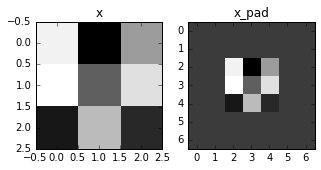

In [13]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

### 3.2 卷积的single step
这一部分，实现卷积操作的单步，就是将过滤器放到输入原始图像的一个位置上。
- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

<img src="images/Convolution_schematic.gif" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : **Convolution operation**<br> with a filter of 2x2 and a stride of 1 (stride = amount you move the window each time you slide) </center></caption>


In [14]:
# GRADED FUNCTION: conv_single_step
# 计算一个过滤器在原始图像的某一位置时的计算结果，输入为原始图像上的窗口矩阵，过滤器也就是W组成的，b偏置，计算结果为一个实数
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    ### START CODE HERE ### (≈ 2 lines of code)
    # Element-wise product between a_slice and W. Add bias.
    s = np.multiply(a_slice_prev,W)+b
    # Sum over all entries of the volume s
    Z = np.sum(s)
    ### END CODE HERE ###

    return Z

In [15]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -23.16021220252078


### 3.3 卷积神经网络-前向传播
这里就要实现一个卷积操作了，就是一个过滤器在原始图片上的滑动，最后计算出一个二维矩阵。

关于在一个（nh,nw,nc）上切割出一个跟过滤器大小相同的块的方法是：使用矩阵的切割:a_slice_prev = a_prev[0:2,0:2,:]表示在a_prev这个三维矩阵上切割2\*2\*nc大小的块。如果窗口移动，则修改对应的索引值。


![切片操作如何定义索引起始位置](https://upload-images.jianshu.io/upload_images/1779926-d5dc7a37ffdae9c6.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

![卷积层后输出矩阵维度计算](https://upload-images.jianshu.io/upload_images/1779926-997214381d5d2822.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)


In [19]:
# GRADED FUNCTION: conv_forward
import math
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Compute the dimensions of the CONV output volume using the formula given above. Hint: use int() to floor. (≈2 lines)
    n_H = np.int(math.floor((n_H_prev - f+2*pad)/stride+1))
    n_W = np.int(math.floor((n_W_prev - f+2*pad)/stride+1))
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.random.rand(m,n_H,n_W,n_C)
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev,pad)
    
    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i,:,:,:]                               # Select ith training example's padded activation
        for h in range(n_H):                           # loop over vertical axis of the output volume
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = stride*h
                    vert_end = vert_start+f
                    horiz_start = stride*w
                    horiz_end = horiz_start+f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                    # 四维矩阵切片时，使用：表示该维度从头到尾，如果是个实数则表示这个维度上的第几个切片，相当于面包切片就得到二维面包片
                    Z[i, h, w, c] = conv_single_step(a_slice_prev,W[:,:,:,c],b[:,:,:,c])
                                        
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [20]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


最后，卷积层还应该包含一个激活函数，我们就直接使用激活函数计算得到：
```python
# Convolve the window to get back one output neuron
Z[i, h, w, c] = ...
# Apply activation
A[i, h, w, c] = activation(Z[i, h, w, c])
```
卷积计算后得到z，再应用激活函数。

## 4.池化层
池化层一般都减少了输入的高和宽，并且可以帮助减少计算，还有助于使特征检测器在输入中的位置更加稳定。共有两种类型的池化层：
- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

池化层没有参数需要在反向传播过程训练。然而，同样是有参数的，比如说过滤器的大小f。

### 4.1 前向池化
池化层没有扩充，计算输出的维度大小公式为：
$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$
$$ n_C = n_{C_{prev}}$$

In [30]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    ### START CODE HERE ###
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = stride*h
                    vert_end = vert_start+f
                    horiz_start = stride*w
                    horiz_end = horiz_start+f
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i,vert_start:vert_end, horiz_start: horiz_end,c]
                    #注意这里取出来一个小块的时候是针对每个通道，因为池化操作是在每一个通道上操作的，所以切片的时候的c表示每个通道
                    #而在卷积操作中的，c代表的过滤器的个数，所以在原始图像上切片时，第4个维度全用上
                    
                    
                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. Use np.max/np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.average(a_prev_slice)
    
    ### END CODE HERE ###
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [31]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 1, "f": 4}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]

mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


现在已经实现了卷积网络的每一层的正向传播了，接下来部分是关于可选部分反向传播的内容。

## 5. 卷积神经网络的反向传播
在现代深度学习框架中，只需要实现正向传播，框架会自己实现反向传播。卷积神经网络的反向传播非常的复杂。如果你想自己实现，可以完成下面作业。早期课程中，实现了简单的全连接的神经网络，使用反向传播来计算代价函数关于每个参数的梯度，同样的，在卷积神经网络中，你也可以计算梯度。

### 5.1 卷积层反向传播
#### 5.1.1 计算dA
卷积层的反向传播比较复杂，如果是简单的Z=WA+b，所以大概是dA\*W，那么在卷积层，我们使用$W_c$表示一个过滤器，然后$dZ_{hw}$表示一个标量，对应的是代价函数关于某一卷积层z在第h行第w列上的梯度值。所以我们使用$W_c$乘以不同的dZ值，这么做来计算反向传播，相当于就是过滤器乘里的每一个窗口，将所有窗口与这个过滤器对应的乘积和计算出来，就是计算dA了。

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
# dZ[i, h, w, c]表示针对第i个样本，和第c个过滤器，所以实际上取出来就是一个切片是个二维矩阵的第h行第w列的一个实数，W[:,:,:,c]是一个三维矩阵，乘出来最后结果也是一个实数。那么也就计算出来了关于每次切下一个窗口内容后这个窗口里面的内容的导数。关于重复的那部分格子就是多次覆盖，最后得到最新值吧，纯属个人理解。

#取出W的第4维的第c组，就是一个三维矩阵，将后面得到的三维数据依次填入
```

#### 5.1.2 计算dW
关于计算W过滤器的导数，关于dw = dz*\da
$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

关于理解dA和dW，就是使用dZ里面的每个值都和对应的窗口矩阵做乘积并且取和，最后也是得到一个矩阵。

#### 5.1.3 计算db
$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

```python
db[:,:,:,c] += dZ[i, h, w, c]
#关于这一行的理解，就是不管前三个维度，dZ[i, h, w, c]是一个实数，所以意思就是将第4维的第c组元素全都置为后面这个值，并且累加。那么最后其实就是把整个b都变成了跟z有关的值。例如一个二维矩阵先把第二列修改，再把第一列修改，那么最后就是把整个b都变了。

#下面是举的例子，心得，对于一个多维向量，要么填入一个实数，要么填入等大小的矩阵数据
np.random.seed(1)
a = np.random.randn(2,2)
b = np.random.randn(3,2)
print(b)
print(a)
print(a[1,1])
b[:,1]= a[1,1]
print(b)
```

In [53]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """
    
    ### START CODE HERE ###
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape  
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m,n_H_prev,n_W_prev,n_C_prev))                          
    dW = np.zeros((f,f,n_C_prev,n_C))
    db = np.zeros((1,1,1,n_C))

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i,:,:,:]
        da_prev_pad = dA_prev_pad[i,:,:,:]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = stride*h
                    vert_end = vert_start+f
                    horiz_start = stride*w
                    horiz_end = horiz_start+f
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] +=  W[:,:,:,c] * dZ[i,h,w,c]
                    dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        #这一行的作用是，根据上面的代码我们计算出来的A导数都是根据padding之后的，所以我们要得到供前一层使用的dA，就应该恢复到原本的大小，把padding去掉
        # pad：-pad加入pad是3，那么从3到-3就将前面和后面的扩充层去掉了
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad,pad:-pad,:]
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [54]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 9.665267084085745
dW_mean = 10.581741275547566
db_mean = 76.37106919563735


### 5.2 池化层反向传播
尽管池化层没有参数需要更新，但是仍然需要反向传播，因为前面的卷积层需要梯度下降。
#### 5.2.1 最大池化反向传播
在实现池化反向传播之前必须实现函数create_mask_from_window() ：
这个函数就像一个面具，就是跟踪最大值的位置，将最大值的位置置为1，其余位置置为0。在平均池化层也很相似，不过使用不同的面具。

- [np.max()]() may be helpful. It computes the maximum of an array.
- If you have a matrix X and a scalar x: `A = (X == x)` will return a matrix A of the same size as X such that:
```
A[i,j] = True if X[i,j] = x
A[i,j] = False if X[i,j] != x
```
- Here, you don't need to consider cases where there are several maxima in a matrix.



In [55]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    
    ### START CODE HERE ### (≈1 line)
    mask = (x ==np.max(x) )
    ### END CODE HERE ###
    
    return mask

In [56]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


为什么我们要跟踪max的位置？因为这是最终影响产出的输入值，因此也就是成本。BackProp相对于成本计算梯度，因此任何影响最终的成本应该有一个非零梯度。因此，BP将“传播”的梯度回到这个特定的输入值，影响了成本。

#### 5.2.2 平均池化-反向传播
在最大池中，对于每个输入窗口，所有对输出的“影响”来自单个输入值——最大值。
平均池，每个输入窗口的元素对输出具有同等的影响。所以实施BackProp，现在你将实现一个辅助函数将每一个位置都贡献了一样的力。

For example if we did average pooling in the forward pass using a 2x2 filter, then the mask you'll use for the backward pass will look like: 
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

In [60]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from shape (≈1 line)
    (n_H, n_W) = shape
    
    # Compute the value to distribute on the matrix (≈1 line)
    average = np.float(dz)/np.float(n_H*n_W)
    
    # Create a matrix where every entry is the "average" value (≈1 line)
    a = np.ones((n_H, n_W))*average
    ### END CODE HERE ###
    
    return a

In [61]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


#### 5.2.3
把池化层的反向传播放到一起。
You will once again use 4 for-loops (iterating over training examples, height, width, and channels). You should use an if/elif statement to see if the mode is equal to 'max' or 'average'. If it is equal to 'average' you should use the distribute_value() function you implemented above to create a matrix of the same shape as a_slice. Otherwise, the mode is equal to 'max', and you will create a mask with create_mask_from_window() and multiply it by the corresponding value of dZ.

In [64]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    
    ### START CODE HERE ###
    
    # Retrieve information from cache (≈1 line)
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros((m,n_H_prev,n_W_prev,n_C_prev))
    
    for i in range(m):                       # loop over the training examples
        
        # select training example from A_prev (≈1 line)
        a_prev =A_prev[i,:,:,:] 
        
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = stride*h
                    vert_end =  vert_start+f
                    horiz_start = stride*w
                    horiz_end = horiz_start+f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += np.multiply(mask,dA[i,h,w,c])
                        
                    elif mode == "average":
                        
                        # Get the value a from dA (≈1 line)
                        da = dA[i,h,w,c]
                        # Define the shape of the filter as fxf (≈1 line)
                        shape = (f,f)
                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
                        
    ### END CODE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

#总结，关于最大池化层的反向就是将对于原始输入图像，这次处理的哪个窗口，就将该窗口的最大值位置置为1，其余位置为0 ，因为对于最大池化层的代价计算来说
#只有最大值发挥了作用，而其他都没有
#关于平均层，则是使用da里面，也就是激活值，看每一个对应的窗口的平均值结果是多少，再除以窗口大小，即计算出对于原始窗口每个格子各除了多少力
#另外，关于池化层，是没有计算z再计算a的过程的，是直接窗口移动计算得到激活值A

In [65]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


关于这节作业，在作业之前总觉得实现起来比较复杂，但通过巧妙的命名规范可以让问题变得简单，以及对numpy多维度矩阵的使用。就比如说，在实现卷积层时，首先考虑一个过滤器在某一个位置的运算，那么就会想多个过滤器，是不是还得循环多次，然而通过将过滤器声明成4维，问题就解决了，就说明有多个过滤器。另外，关于窗口移动之后，如何知道它的位置，取出对应元素，采用的切片操作，并且通过先计算最后可能得到几次移动，再根据移动乘上步长，再去原始图像矩阵里面进行切片。当然反向传播是比较难理解的，尽量理解吧。